In [2]:
%reload_ext kedro.ipython

[02/19/25 20:58:41] INFO     Using                                                                  ]8;id=625036;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/framework/project/__init__.py\__init__.py]8;;\:]8;id=325821;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/framework/project/__init__.py#270\270]8;;\
                             '/home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/sit                
                             e-packages/kedro/framework/project/rich_logging.yml' as logging                       
                             configuration.                                                                        

                    INFO     Registered line magic '%reload_kedro'                                   ]8;id=173812;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=100697;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=173254;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=164907;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=620914;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=213315;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /home/guilherme/Projects/credit-risk-analysis.                                        
                             To set a different path, run '%reload_kedro <project_root>'                           

[02/19/25 20:58:41] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=425371;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=759304;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro_telemetry/plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[02/19/25 20:58:42] INFO     Kedro project Credit Risk Analysis                                     ]8;id=497685;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=38231;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=428583;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=163991;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=101491;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=571898;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#153\153]8;;\

# Importando bibliotecas

In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from credit_risk_analysis.utils.utils import evaluate_model, plot_shap_dependence, separa_colunas
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

# Funções úteis

In [3]:
def verify(df):
    print(df.shape)
    display(df.head())
    display(df.tail())

def display_info_dataframe(df):
    df_info = pd.concat([df.dtypes, df.isna().sum(), df.nunique()], axis=1)
    df_info.columns = ['dtype', 'qtd_nulos', 'qtd_unicos']
    display(df_info)


# Lendo as bases

In [4]:
df_completo = catalog.load("spine")

[02/19/25 20:16:22] INFO     Loading data from spine (ParquetDataset)...                        ]8;id=934830;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=995701;file:///home/guilherme/Projects/credit-risk-analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#390\390]8;;\

In [5]:
verify(df_completo)

(77195, 19)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RZ_RENDA_FUNC,VL_TAXA,ATRASO,FLAG_MAU
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,2013-08-22,99,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,2482.597059,0,0
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,2013-08-22,99,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1241.298879,1,0
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,2013-08-22,99,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1218.494004,1,0
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,2013-08-22,99,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,93.735900,6,1
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,2013-08-22,99,SERVICOS,YAHOO,PEQUENO,65,NaN,NaN,NaN,1489.558515,0,0


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,RZ_RENDA_FUNC,VL_TAXA,ATRASO,FLAG_MAU
77190,2951563549197799278,2021-06,2021-06-30,2021-07-16,2021-07-16,89980.00,5.99,2000-08-15,11,COMERCIO,AOL,PEQUENO,13,280343.0,161.0,1741.260870,5389.802000,0,0
77191,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99,2021-04-08,19,INDUSTRIA,GMAIL,GRANDE,25,235315.0,87.0,2704.770115,2530.116100,0,0
77192,5860276371789140450,2021-06,2021-06-30,2021-07-16,2021-07-16,20921.50,5.99,2011-02-15,91,SERVICOS,HOTMAIL,GRANDE,67,100006.0,126.0,793.698413,1253.197850,0,0
77193,2814790209436551216,2021-06,2021-06-30,2021-07-16,2021-07-16,90231.05,6.99,2021-05-13,NA,SERVICOS,YAHOO,MEDIO,14,NaN,NaN,NaN,6307.150395,0,0
77194,8343941262792249232,2021-06,2021-06-30,2021-08-16,2021-08-16,20736.51,4.99,2019-05-28,11,INDUSTRIA,HOTMAIL,GRANDE,31,97599.0,116.0,841.370690,1034.751849,0,0


In [6]:
display_info_dataframe(df_completo)

,dtype,qtd_nulos,qtd_unicos
ID_CLIENTE,int64,0,1188
SAFRA_REF,object,0,35
DATA_EMISSAO_DOCUMENTO,object,0,1040
DATA_PAGAMENTO,datetime64[ns],0,920
DATA_VENCIMENTO,datetime64[ns],0,955
VALOR_A_PAGAR,float64,0,68334
TAXA,float64,0,5
DATA_CADASTRO,object,0,695
DDD,object,0,70
SEGMENTO_INDUSTRIAL,object,0,4


# Modelagem

## Features preditivas

In [7]:
pred_cols = [
    'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'RZ_RENDA_FUNC', 'VL_TAXA',
    'DDD', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'
]

## Divisão da base

In [8]:
df_completo['SAFRA_REF'].max()

'2021-06'

In [9]:
df_dev = df_completo[df_completo['SAFRA_REF']<'2021-03'].copy()
df_oot = df_completo[df_completo['SAFRA_REF']>='2021-03'].copy()

In [10]:
df_treino, df_teste = train_test_split(df_dev,test_size=0.3,random_state=111)

In [11]:
df_treino.shape, df_teste.shape, df_oot.shape

((47243, 19), (20248, 19), (9704, 19))

In [12]:
df_treino[~df_treino['ID_CLIENTE'].isin(df_oot['ID_CLIENTE'])].shape

(2497, 19)

In [13]:
df_teste[~df_teste['ID_CLIENTE'].isin(df_oot['ID_CLIENTE'])].shape

(1031, 19)

- Infelizmente, não será possível remover todos os clientes da base de validação out-of-time das bases de treino e teste por conta da volumetria ficar muito baixa.

## Baseline com todas as variáveis

TREINO:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     43862
           1       0.47      0.94      0.63      3381

    accuracy                           0.92     47243
   macro avg       0.73      0.93      0.79     47243
weighted avg       0.96      0.92      0.93     47243

AUC Test 0.9795988934993085
KS Test 84.6


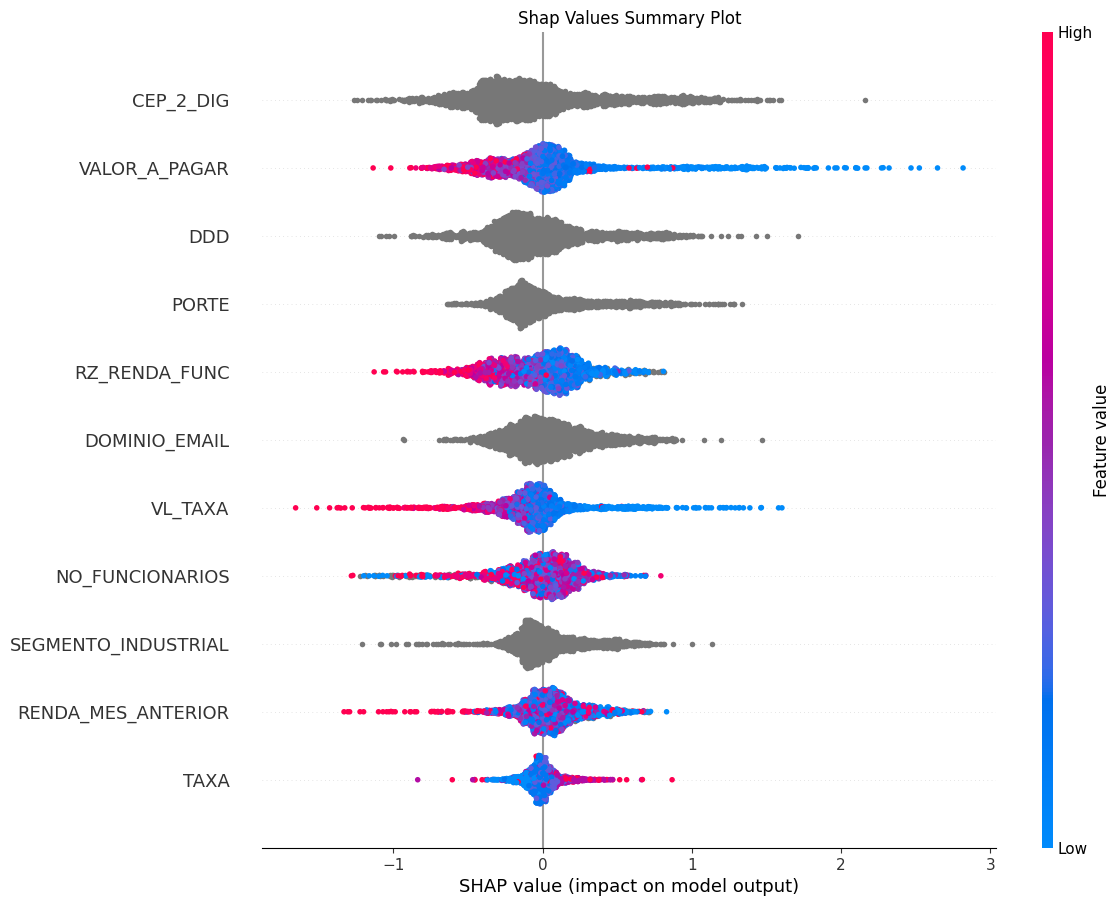

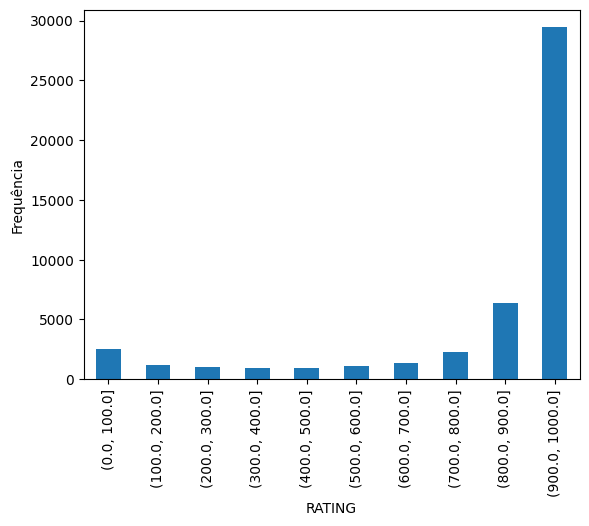

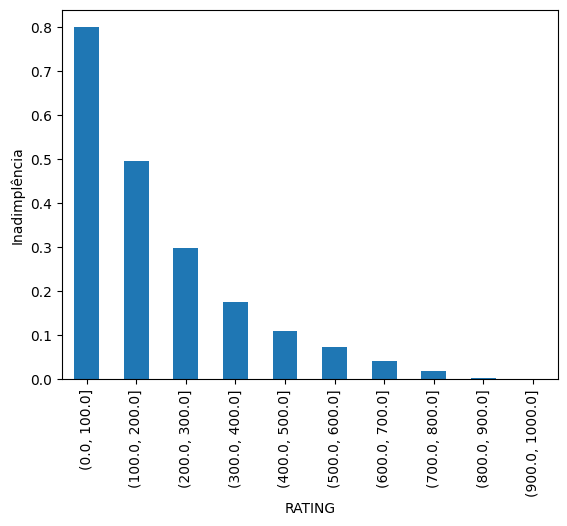

TESTE:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18847
           1       0.42      0.84      0.56      1401

    accuracy                           0.91     20248
   macro avg       0.70      0.88      0.75     20248
weighted avg       0.95      0.91      0.92     20248

AUC Test 0.9404856463333897
KS Test 75.52


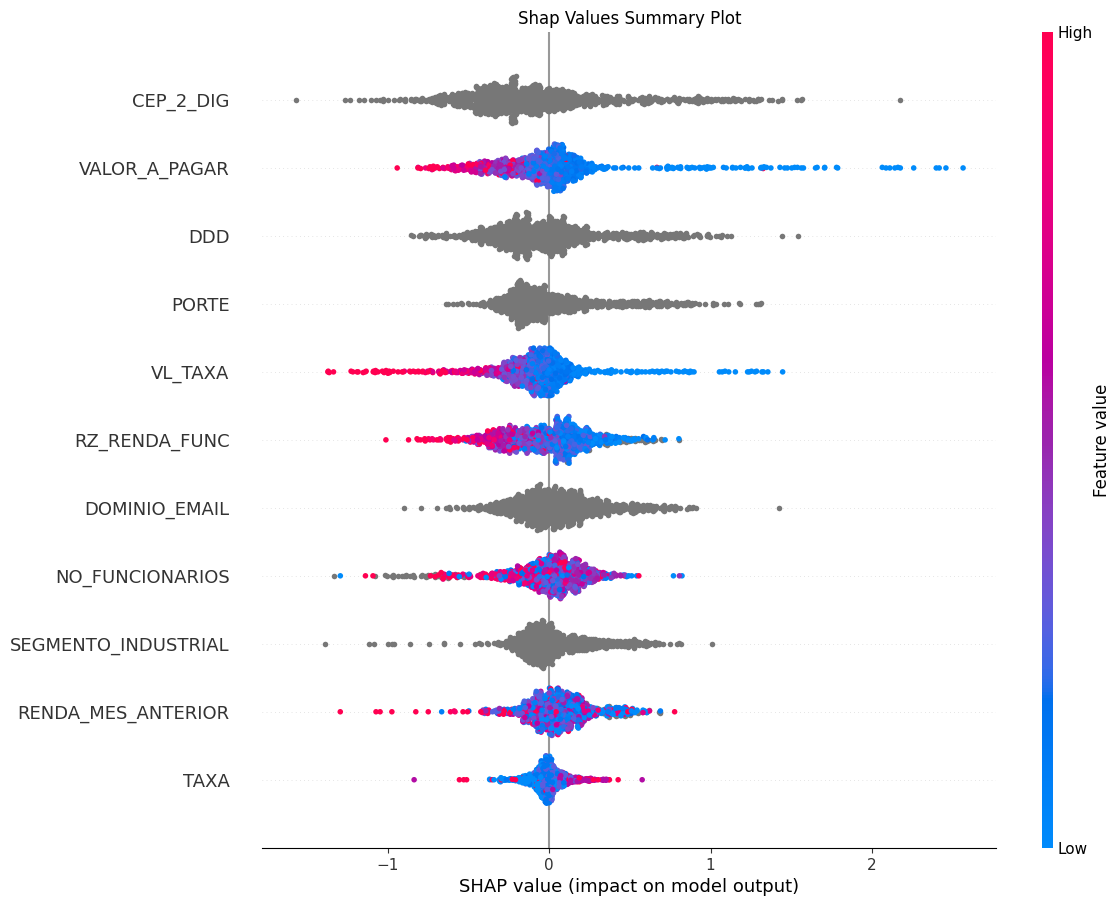

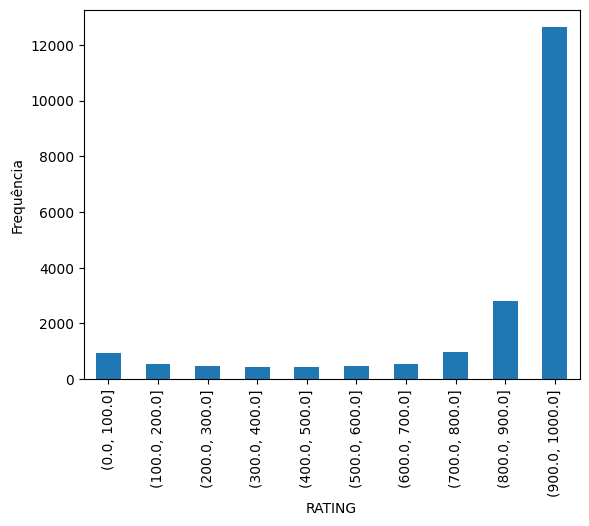

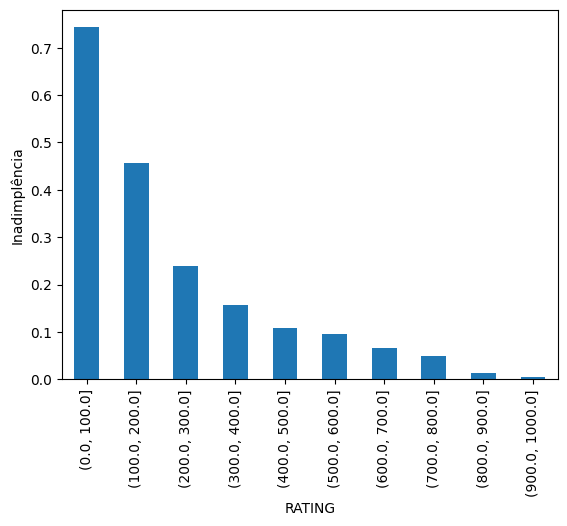

VALIDAÇÂO:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      9094
           1       0.41      0.79      0.54       610

    accuracy                           0.92      9704
   macro avg       0.70      0.86      0.75      9704
weighted avg       0.95      0.92      0.93      9704

AUC Test 0.9098511178330515
KS Test 69.45


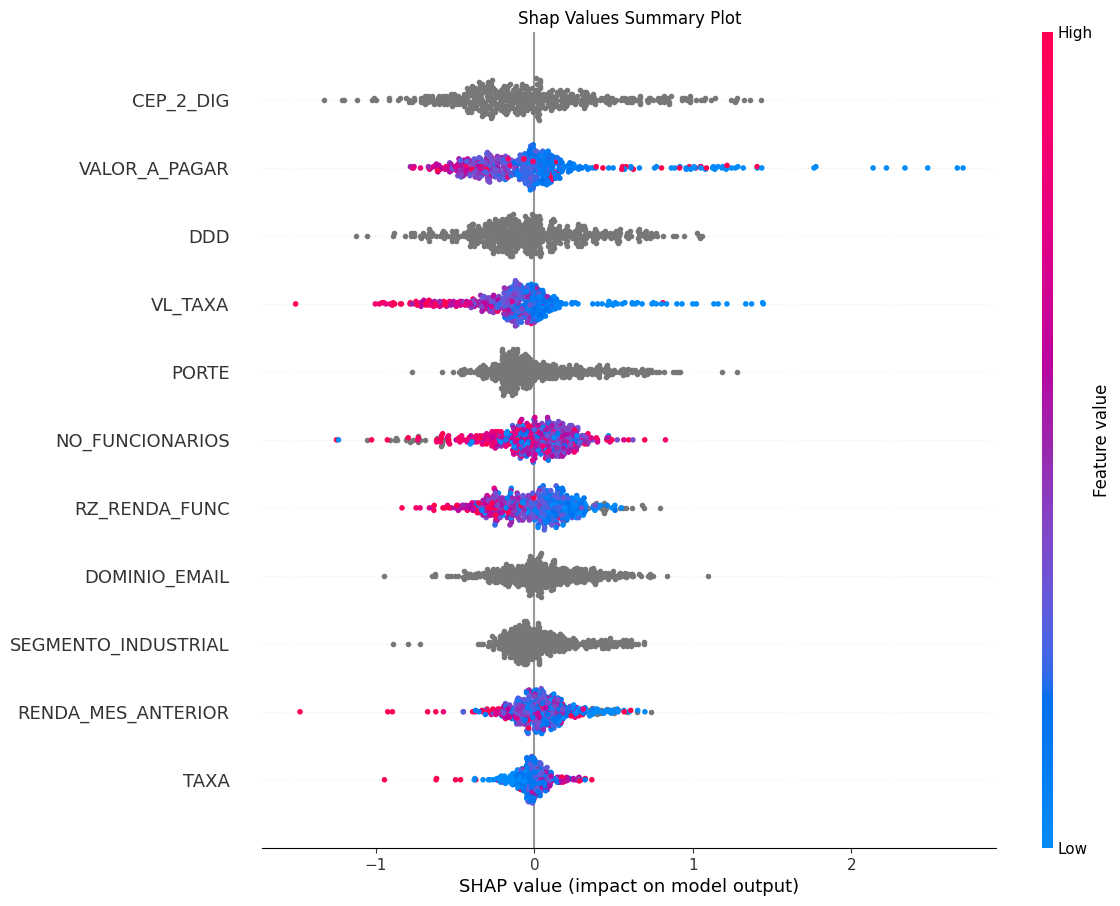

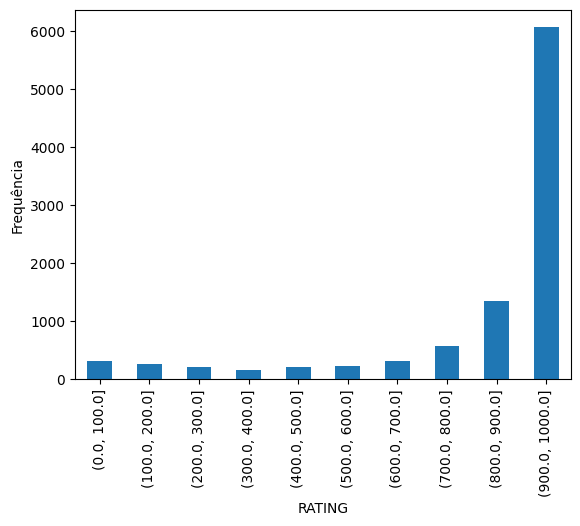

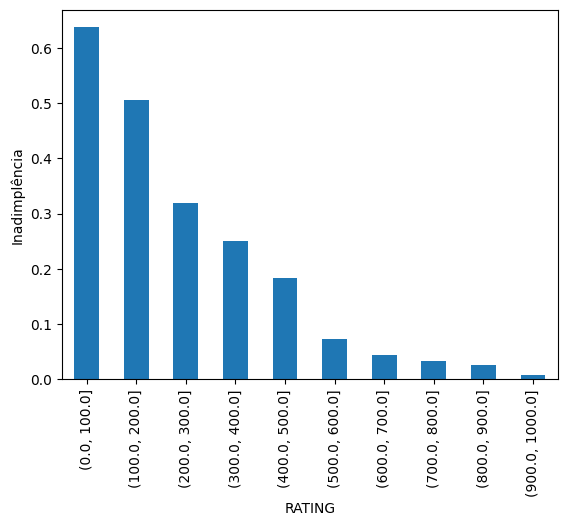

In [14]:
df_train =  df_treino.copy()
df_test = df_teste.copy()
df_val = df_oot.copy()

target = 'FLAG_MAU'
to_plot = True

useful_cols = pred_cols
cat_features = np.where(df_treino[useful_cols].dtypes==object)[0]
model = CatBoostClassifier(auto_class_weights='Balanced',random_state=2,cat_features=cat_features,verbose=0)
model.fit(df_train[useful_cols],df_train[target])

print('TREINO:')
evaluate_model(model = model ,model_features=useful_cols,df = df_train,target = target,to_plot=True)

print('TESTE:')
evaluate_model(model = model ,model_features=useful_cols,df = df_test,target = target,to_plot=True)

print('VALIDAÇÂO:')
evaluate_model(model = model ,model_features=useful_cols,df = df_val,target = target,to_plot=True)

## SHAP Dependence Plots

### Treino

<Figure size 1600x1000 with 0 Axes>

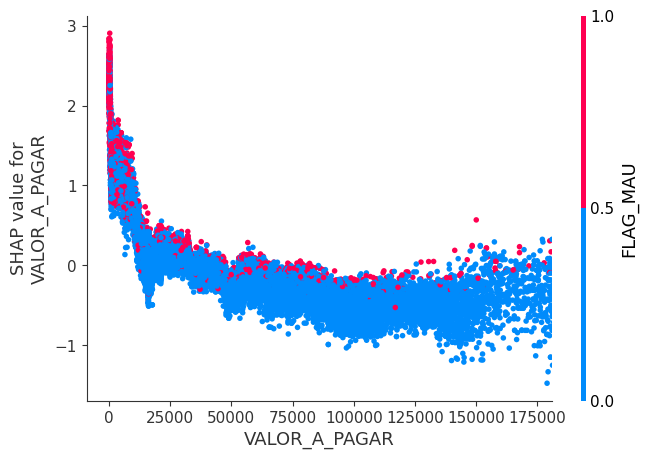

<Figure size 1600x1000 with 0 Axes>

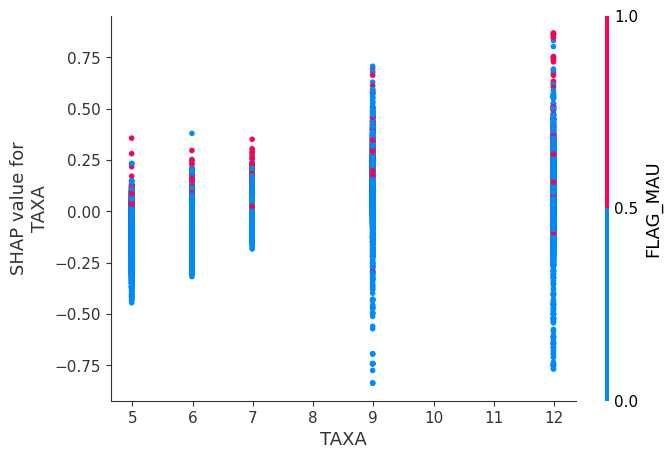

<Figure size 1600x1000 with 0 Axes>

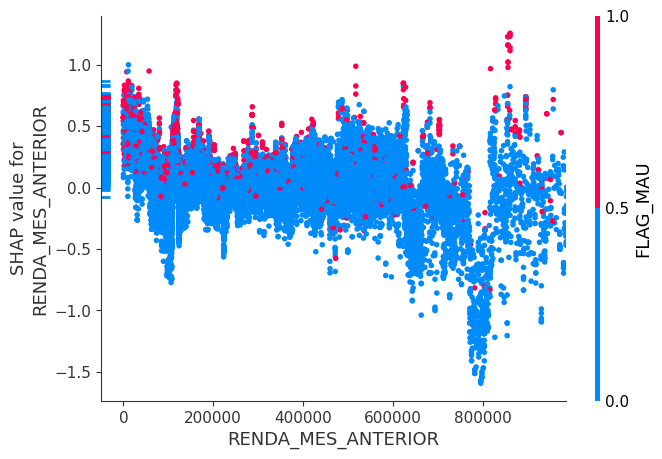

<Figure size 1600x1000 with 0 Axes>

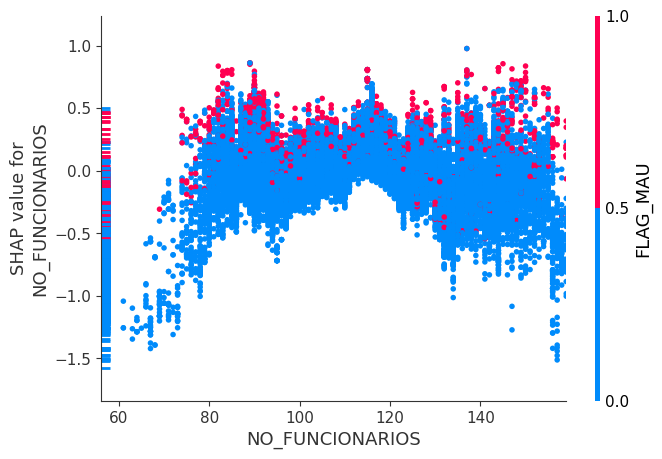

<Figure size 1600x1000 with 0 Axes>

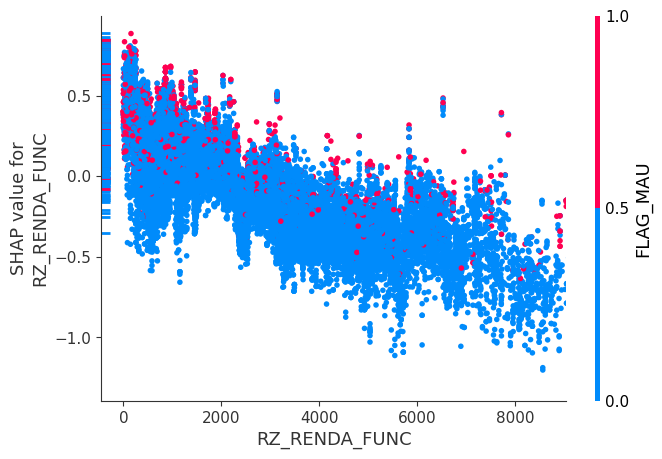

<Figure size 1600x1000 with 0 Axes>

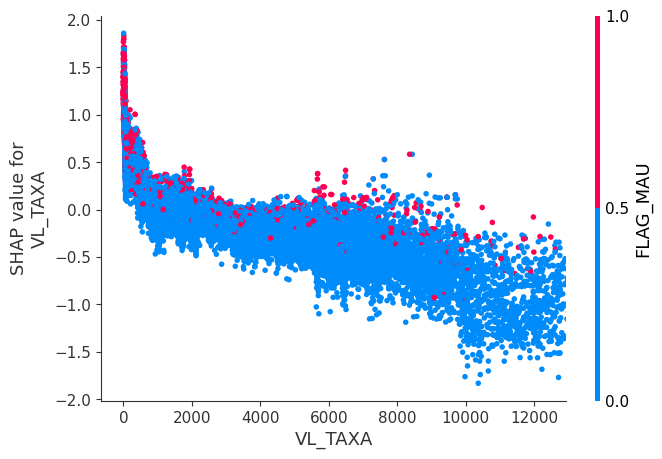

<Figure size 1600x1000 with 0 Axes>

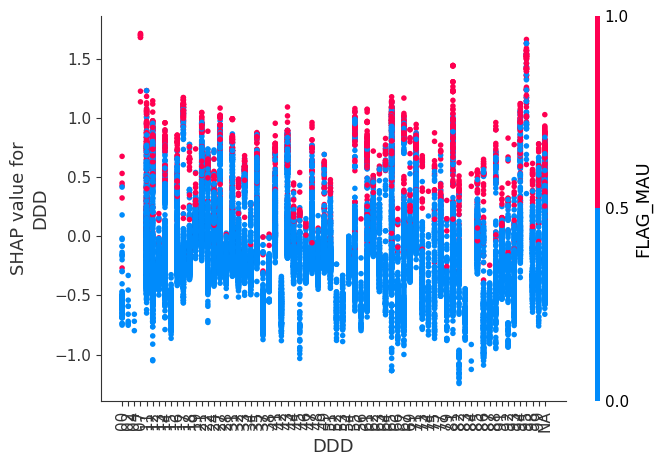

<Figure size 1600x1000 with 0 Axes>

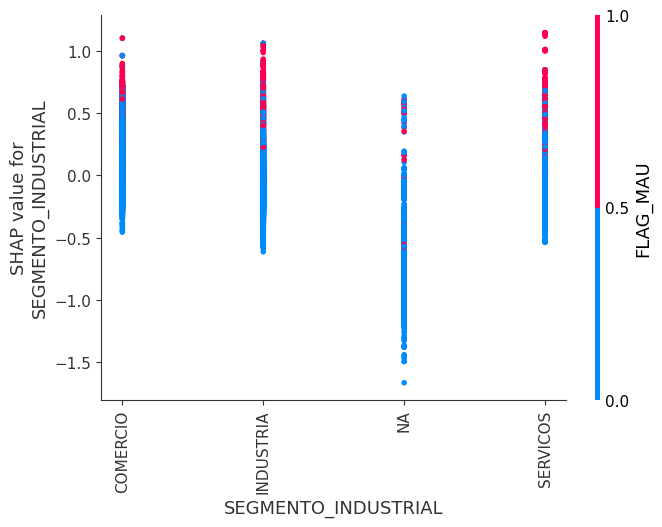

<Figure size 1600x1000 with 0 Axes>

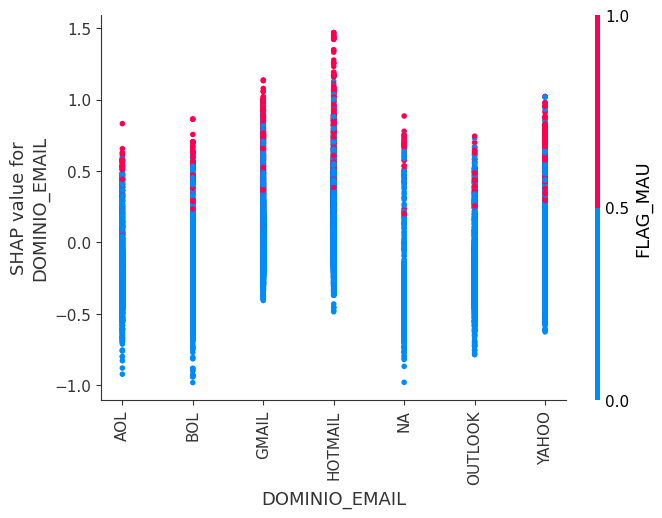

<Figure size 1600x1000 with 0 Axes>

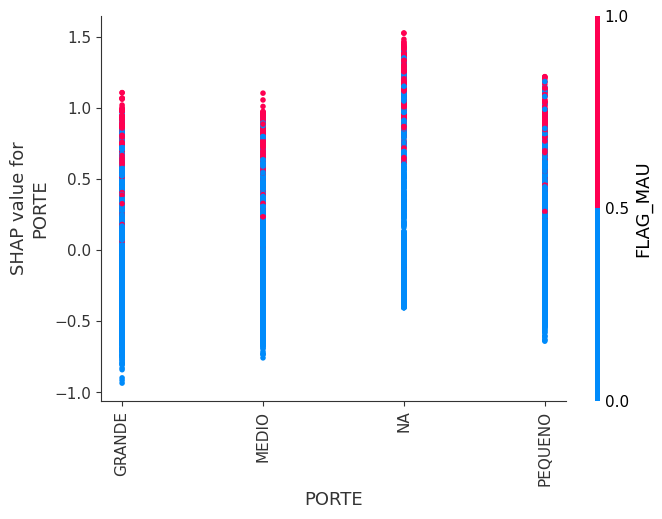

<Figure size 1600x1000 with 0 Axes>

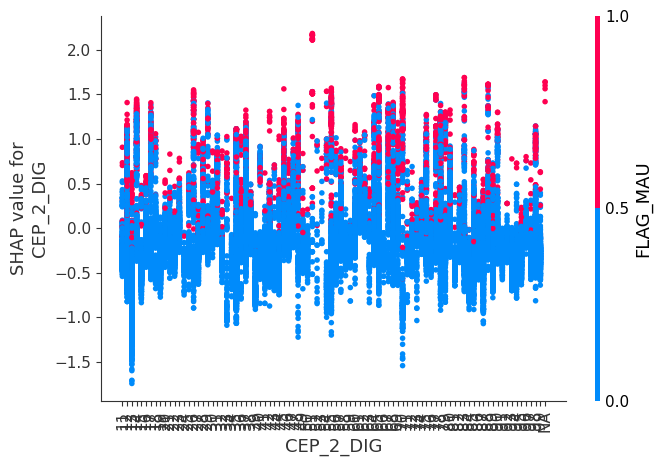

In [15]:
plot_shap_dependence(model=model, df=df_train, model_features=useful_cols, target=target)

### Validação out-of-time

<Figure size 1600x1000 with 0 Axes>

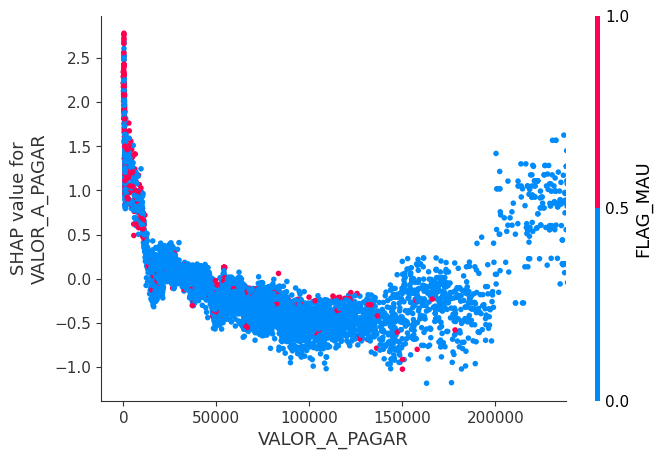

<Figure size 1600x1000 with 0 Axes>

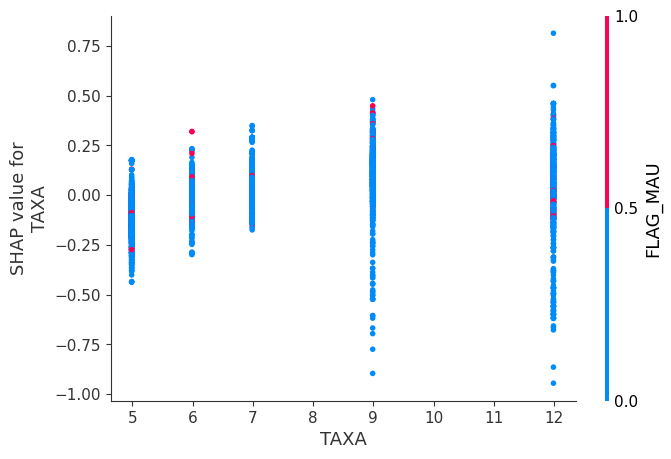

<Figure size 1600x1000 with 0 Axes>

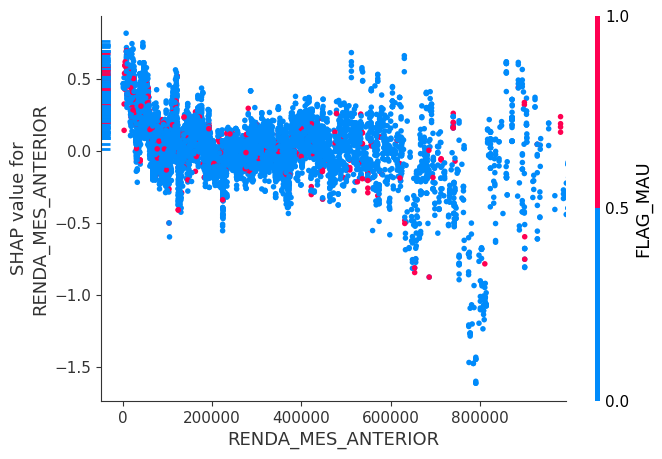

<Figure size 1600x1000 with 0 Axes>

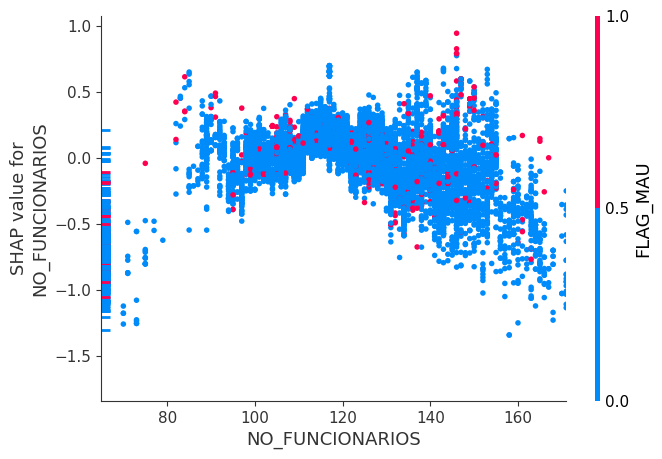

<Figure size 1600x1000 with 0 Axes>

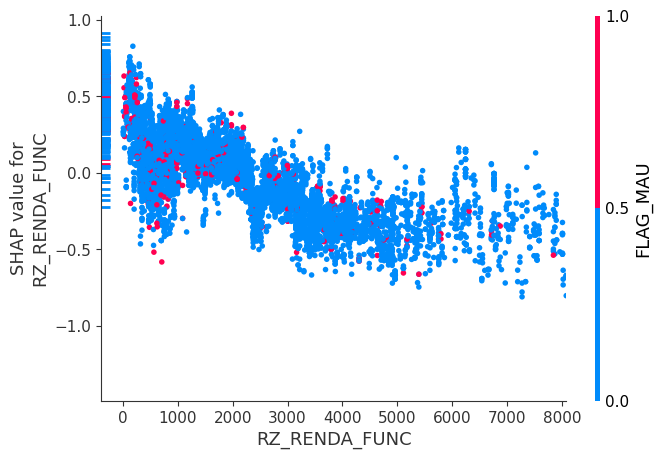

<Figure size 1600x1000 with 0 Axes>

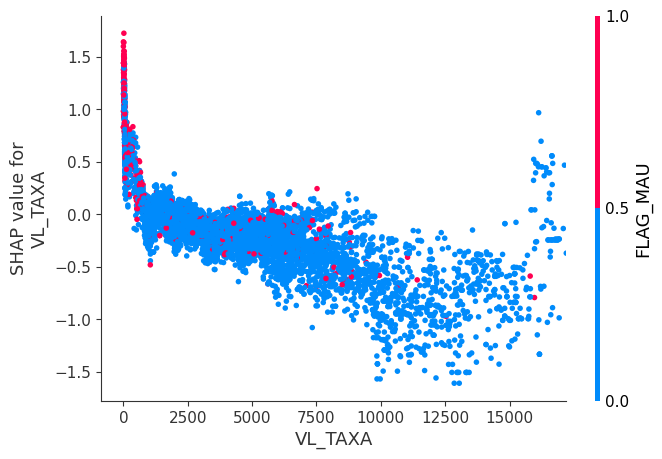

<Figure size 1600x1000 with 0 Axes>

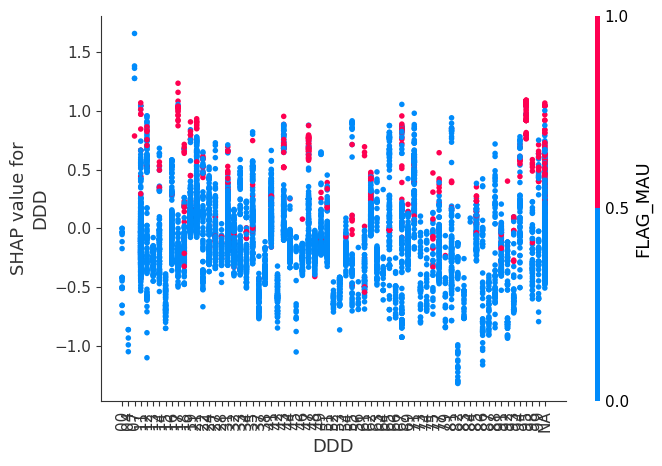

<Figure size 1600x1000 with 0 Axes>

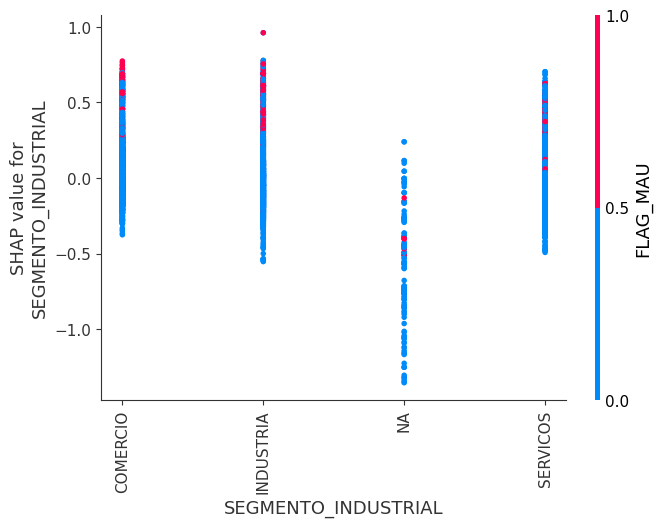

<Figure size 1600x1000 with 0 Axes>

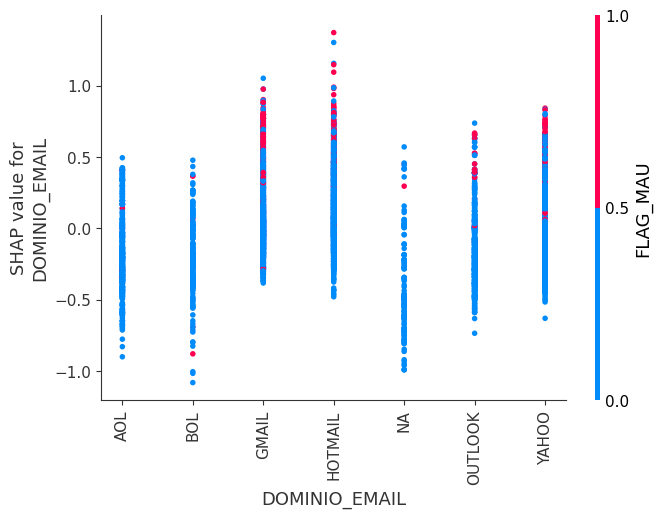

<Figure size 1600x1000 with 0 Axes>

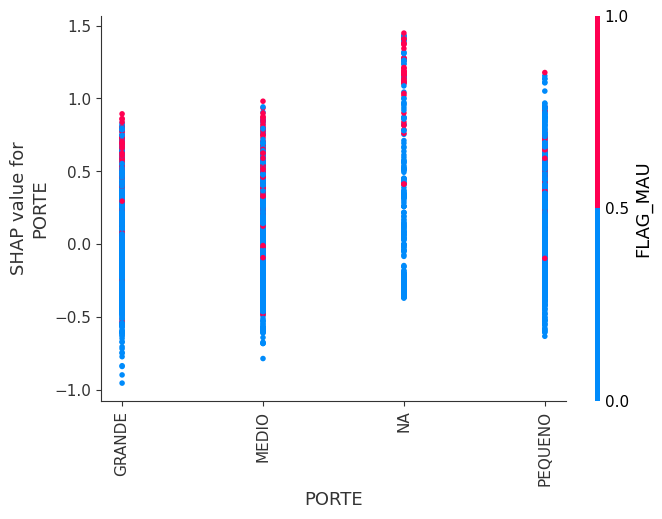

<Figure size 1600x1000 with 0 Axes>

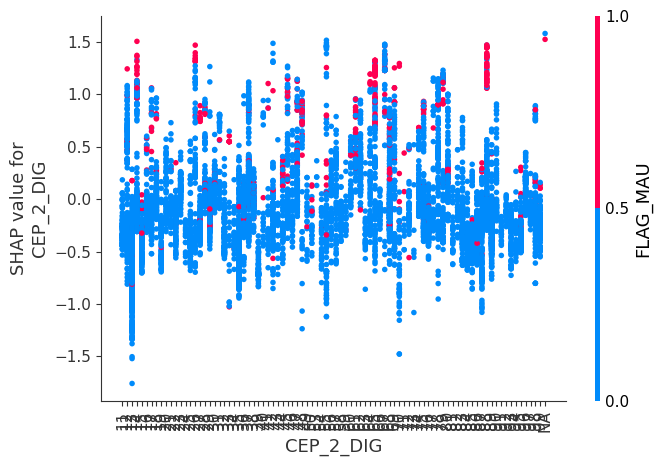

In [16]:
plot_shap_dependence(model=model, df=df_val, model_features=useful_cols, target=target)

A partir da análise dos dependence plots e de testes de modelo, serão removidas as seguintes variáveis:
- NO_FUNCIONARIOS, por não apresentar grande importância e por estar correlacionada com a variável 'PORTE'
- DDD, por estar correlacionada com uma variável de maior importância, a 'CEP_2_DIG'
- SEGMENTO_INDUSTRIAL, por ganho de performance

## Seleção de hiperparâmetros

In [25]:
selected_cols = ['VALOR_A_PAGAR',
                'TAXA',
                'RENDA_MES_ANTERIOR',
                # 'NO_FUNCIONARIOS',
                'RZ_RENDA_FUNC',
                'VL_TAXA',
                # 'DDD',
                # 'SEGMENTO_INDUSTRIAL',
                'DOMINIO_EMAIL',
                'PORTE',
                'CEP_2_DIG'
                ]

In [26]:
num,tex = separa_colunas(df_completo[selected_cols])

In [27]:
target = 'FLAG_MAU'

df_train =  df_treino[selected_cols+[target]].copy()
df_test = df_teste[selected_cols+[target]].copy()
df_val = df_oot[selected_cols+[target]].copy()

def objective(trial):
  model = CatBoostClassifier(
  #         iterations=trial.suggest_int("iterations", 100, 1500),
      learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      depth=trial.suggest_int("depth", 2, 10),
      l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
      bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian","MVS","Bernoulli"]),
      random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
  #         bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
      auto_class_weights = trial.suggest_categorical('auto_class_weights',[None, "Balanced"]),
      od_type=trial.suggest_categorical("od_type", ["Iter"]),
      od_wait=trial.suggest_int("od_wait", 100, 150),
      cat_features = tex,
      verbose=False,
      random_state = 1111
  )
  model.fit(df_train[selected_cols], df_train[target])
  y_pred_test = model.predict(df_test[selected_cols])
  y_pred_oot = model.predict(df_val[selected_cols])

  auc_test = roc_auc_score(df_test[target], y_pred_test)
  auc_oot = roc_auc_score(df_val[target], y_pred_oot)
  mean_auc = (auc_test + auc_oot)/2 - abs(auc_test - auc_oot)
  return mean_auc

In [28]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2025-02-19 20:23:43,234] A new study created in memory with name: catboost
[I 2025-02-19 20:24:01,014] Trial 0 finished with value: 0.7951264688457232 and parameters: {'learning_rate': 0.006824078427098834, 'depth': 8, 'l2_leaf_reg': 1.0026370484058323e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 4.746154837062843e-07, 'auto_class_weights': 'Balanced', 'od_type': 'Iter', 'od_wait': 127}. Best is trial 0 with value: 0.7951264688457232.
[I 2025-02-19 20:24:16,240] Trial 1 finished with value: 0.6057513669806854 and parameters: {'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 5.6982725955953586e-05, 'auto_class_weights': None, 'od_type': 'Iter', 'od_wait': 110}. Best is trial 0 with value: 0.7951264688457232.
[I 2025-02-19 20:25:01,799] Trial 2 finished with value: 0.5726807890895367 and parameters: {'learning_rate': 0.03994745694560917, 'depth': 10, 'l2_leaf_reg': 1.3622028406348663e-05, 

In [29]:
best_trial = study.best_trial

In [30]:
best_trial.params


{
    'learning_rate': 0.06409200096796018,
    'depth': 3,
    'l2_leaf_reg': 2.470378349559226e-07,
    'bootstrap_type': 'Bayesian',
    'random_strength': 2.226266870634716,
    'auto_class_weights': 'Balanced',
    'od_type': 'Iter',
    'od_wait': 137
}

## Modelo final

In [31]:
model_final = CatBoostClassifier(**best_trial.params,cat_features = tex, verbose=False,random_state = 1111)
model_final.fit(df_train[selected_cols], df_train[target])

TREINO:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     43862
           1       0.32      0.87      0.47      3381

    accuracy                           0.86     47243
   macro avg       0.66      0.86      0.69     47243
weighted avg       0.94      0.86      0.89     47243

AUC Test 0.9371496289396049
KS Test 73.14


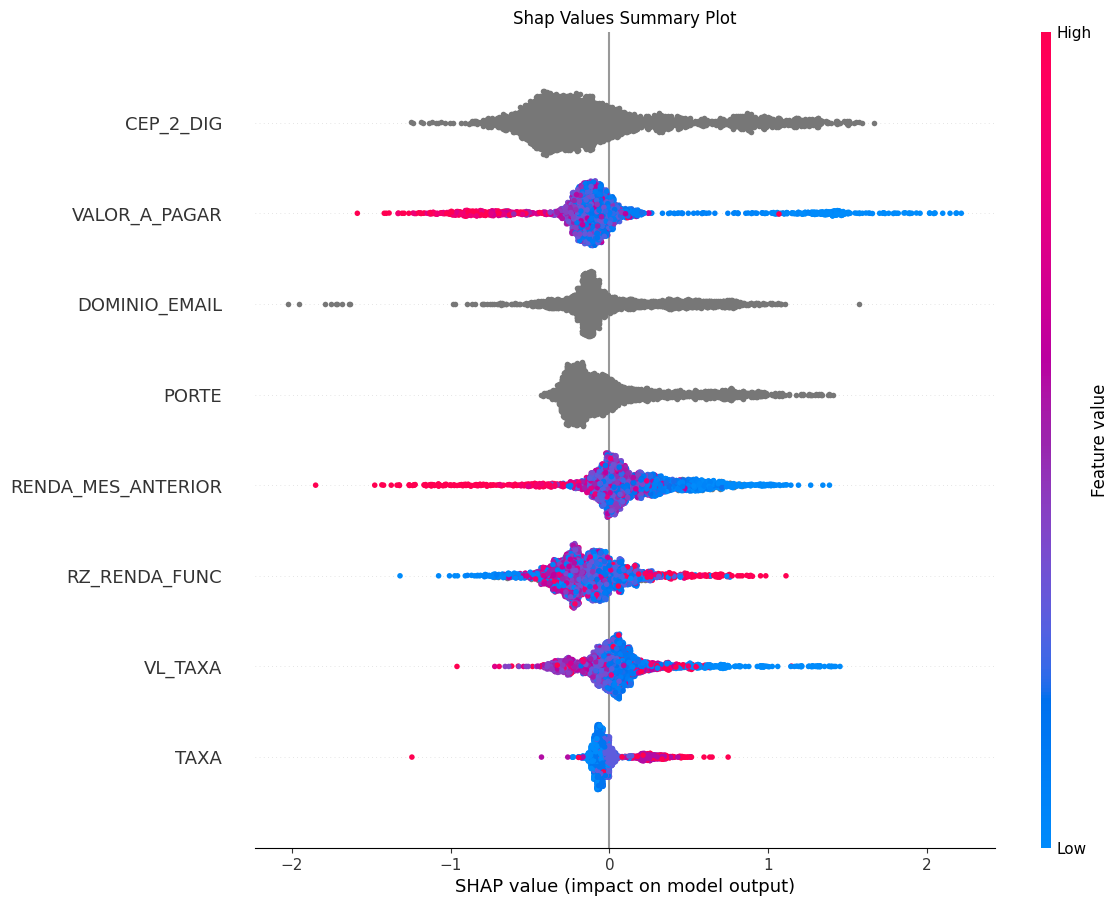

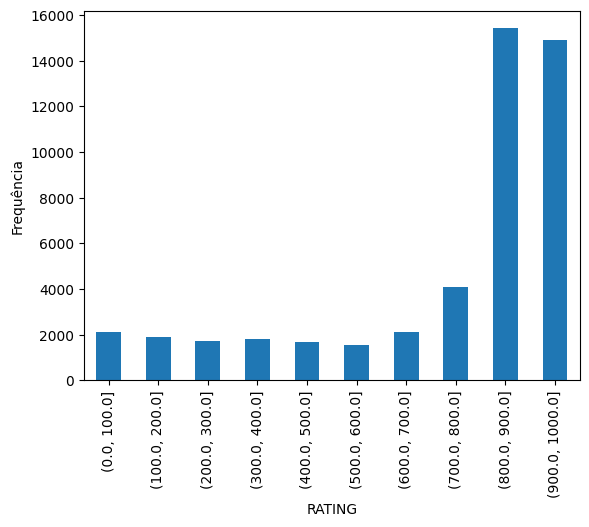

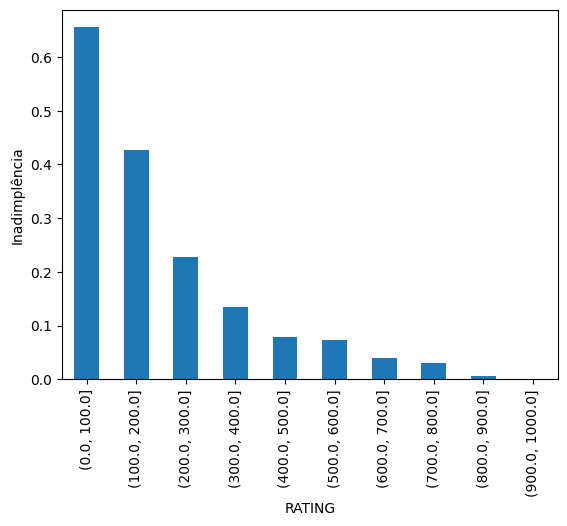

TESTE:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     18847
           1       0.31      0.84      0.45      1401

    accuracy                           0.86     20248
   macro avg       0.65      0.85      0.68     20248
weighted avg       0.94      0.86      0.89     20248

AUC Test 0.915555129367948
KS Test 69.69


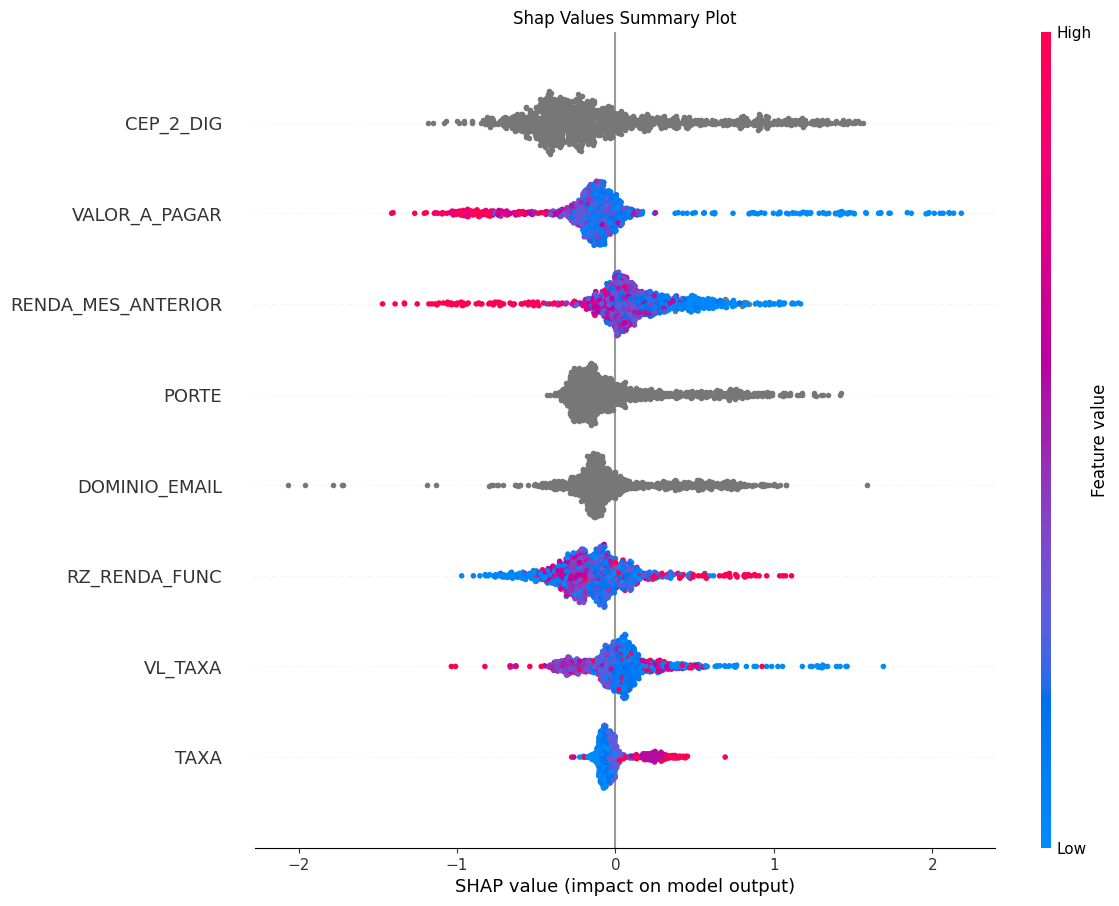

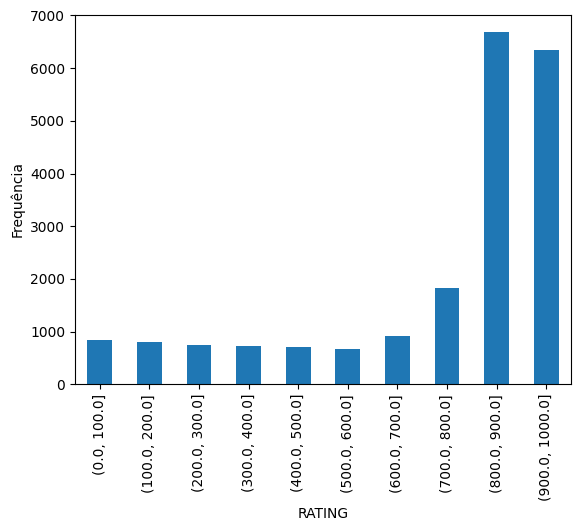

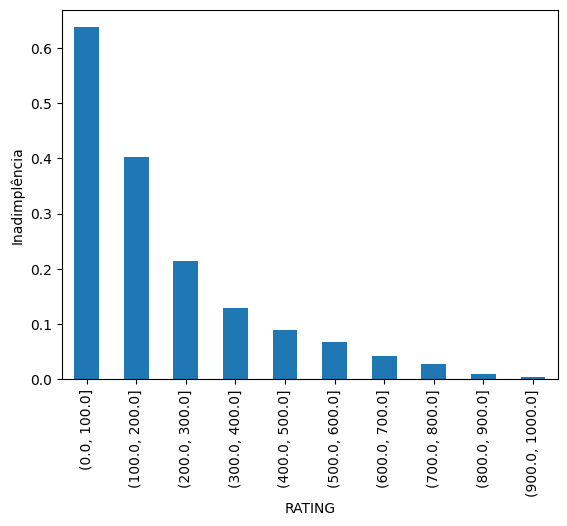

VALIDAÇÂO:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      9094
           1       0.29      0.82      0.43       610

    accuracy                           0.86      9704
   macro avg       0.64      0.84      0.67      9704
weighted avg       0.94      0.86      0.89      9704

AUC Test 0.8960019576950394
KS Test 69.1


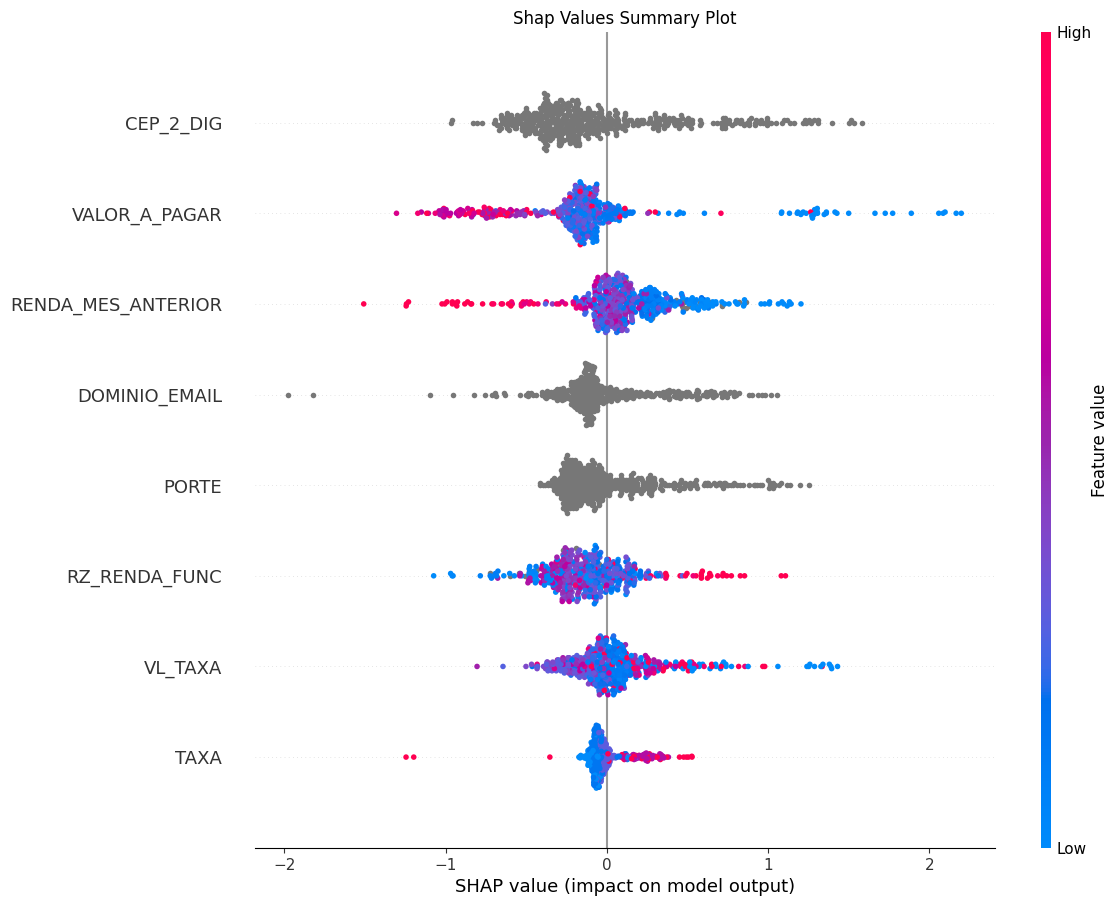

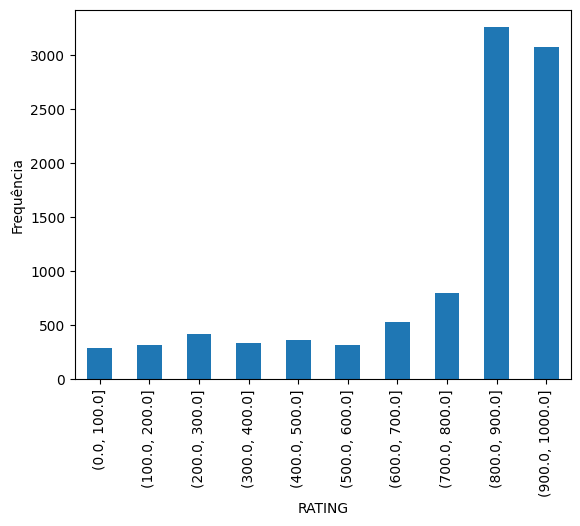

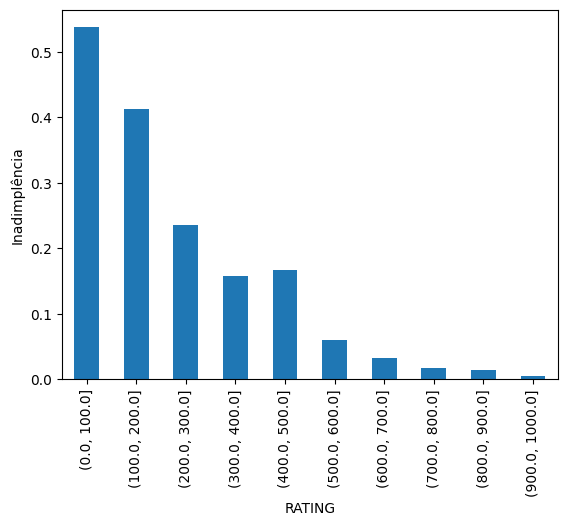

In [32]:
print('TREINO:')
evaluate_model(model = model_final ,model_features=selected_cols,df = df_train,target = target,to_plot=True)

print('TESTE:')
evaluate_model(model = model_final ,model_features=selected_cols,df = df_test,target = target,to_plot=True)

print('VALIDAÇÂO:')
evaluate_model(model = model_final ,model_features=selected_cols,df = df_val,target = target,to_plot=True)

- Após a otimização de hiperparâmetros e seleção de variáveis, podemos ver que a diferença de performance entre as bases de desenvolvimento e a base de validação out-of-time diminuiu, o que mostra ganhos na redução de overfitting a um período de tempo específico.